In [1]:
import numpy as np

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN, KMeans
from sklearn.manifold import TSNE
from tqdm import tqdm
from spherecluster import SphericalKMeans

import matplotlib.pyplot as plt

/home/egor/anaconda3/envs/topic-dynamics/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
RANDOM_SEED = 42

In [3]:
library_embeddings = np.load('../models/libraries_embeddings.npy')

In [4]:
library_embeddings.shape

(8652, 32)

In [5]:
library_embeddings /= np.linalg.norm(library_embeddings, axis=1, keepdims=True)

In [6]:
libraries = [line.strip() for line in open('../models/libraries_embeddings_dependencies.txt')]

In [7]:
len(libraries)

8652

In [8]:
def run_kmeans(n_clusters, embedding, init='k-means++', normalize=False):
    if normalize:
        embedding = embedding.copy() / np.linalg.norm(embedding, axis=1, keepdims=True)
    clusterizer = KMeans(n_clusters, init=init, random_state=RANDOM_SEED).fit(embedding)
    labels = clusterizer.predict(embedding)
    return clusterizer, labels

In [9]:
def print_closest(ind, k=20):
    print(f"Library: {libraries[ind]}")
    for other in list(reversed(np.argsort(cosine_sims[ind])))[:k]:
        print(f"{libraries[other]} | {cosine_sims[ind,other]:.4f}")

In [10]:
def compute_score(embeddings, cluster_centers):
    return embeddings.dot(cluster_centers.T).max(axis=1).sum()

In [ ]:
kmeans_scores = []
uniform_scores = []
trials = np.array([2, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64])

for n_clusters in tqdm(trials):
    kmeans, clusters = run_kmeans(n_clusters, library_embeddings)
    kmeans_scores.append(compute_score(library_embeddings, kmeans.cluster_centers_))
    uniform_scores.append([])
    for t in range(100):
        uniform_centers = np.random.normal(size=(n_clusters, 32))
        uniform_centers /= np.linalg.norm(uniform_centers, axis=1, keepdims=True)
        uniform_scores[-1].append(compute_score(library_embeddings, uniform_centers))

 94%|█████████▍| 16/17 [03:54<00:16, 16.45s/it]

In [ ]:
kmeans_scores = np.array(kmeans_scores)
uniform_scores = np.array(uniform_scores)
mean_scores = uniform_scores.mean(axis=1)
std_scores = uniform_scores.std(axis=1)

In [ ]:
plt.figure(figsize=(20,10))
plt.xticks(trials)
plt.errorbar(x=trials, y=kmeans_scores-mean_scores, yerr=std_scores, fmt='o')

In [ ]:
np.savetxt('gap_statistic.txt', np.column_stack([trials, kmeans_scores, mean_scores, std_scores]), fmt='%.3f')

In [ ]:
N_CLUSTERS = 44

In [ ]:
kmeans, labels = run_kmeans(N_CLUSTERS, library_embeddings)

In [ ]:
def get_idf(line):
    lib, val = line.strip().split(';')
    return lib, float(val)

idfs = [get_idf(line) for line in open('../models/idfs.txt')]

In [ ]:
idfs.sort(key=lambda lib: libraries.index(lib[0]))

In [ ]:
idfs = np.array([idf[1] for idf in idfs])

In [ ]:
labels = np.array(labels)

In [ ]:
from analysis import get_name, get_year, read_dependencies

In [ ]:
reqs = read_dependencies()

In [ ]:
dep_index = {dep: i for i, dep in enumerate(libraries)}

In [ ]:
cluster_labels = [''] * N_CLUSTERS
cluster_repos = [''] * N_CLUSTERS

for c in range(N_CLUSTERS):
    inds = np.where(labels == c)[0]
    sorted_by_idf = np.argsort(idfs[inds])
    
    closest_repos = []
    edge = 4
    while len(closest_repos) < 20:
        edge -= 1
        closest_repos = []
        for repo, deps in reqs.items():
            year = get_year(repo)
            if year != '2020':
                continue
            name = get_name(repo)
            total_c = 0
            for dep in deps:
                if labels[dep_index[dep]] == c:
                    total_c += 1
            if total_c < edge:
                continue
            closest_repos.append((total_c / len(deps), name))
        closest_repos.sort(reverse=True)
        
    
    print('~'*20)
    print(f'Cluster {c}:')
    for ind, (dist, repo_name) in zip(sorted_by_idf[:20], closest_repos):
        repo_under_ind = repo_name.rfind('_')
        repo_name = f'https://github.com/{repo_name[:repo_under_ind]}/{repo_name[repo_under_ind+1:]}'
        true_ind = inds[ind]
        print(f'{repo_name} | {dist:.3f} | {libraries[true_ind]} | {cosine(library_embeddings[true_ind], kmeans.cluster_centers_[c]):.3f}')
        cluster_labels[c] += " | " + libraries[true_ind]
    print('~'*20)
    print()

In [ ]:
def readfile(f):
    labels = []
    for line in open(f):
        line = line.strip()
        if line != '':
            labels.append(line)
    return labels

In [ ]:
examples = np.array(readfile('examples.txt')).reshape((-1, 3))
common_labels = readfile('labels.txt')
print(len(examples), len(common_labels))
common_labels = [f"{label} | {', '.join(exs)}" for label, exs in zip(common_labels, examples)]

/home/egor/anaconda3/envs/topic-dynamics/lib/python3.8/site-packages/matplotlib/backends/_backend_pdf_ps.py:102: RuntimeWarning: Glyph 27 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/home/egor/anaconda3/envs/topic-dynamics/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 27 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/egor/anaconda3/envs/topic-dynamics/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 27 missing from current font.
  font.set_text(s, 0, flags=flags)


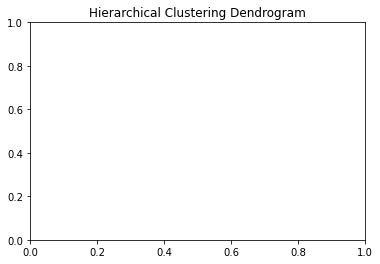

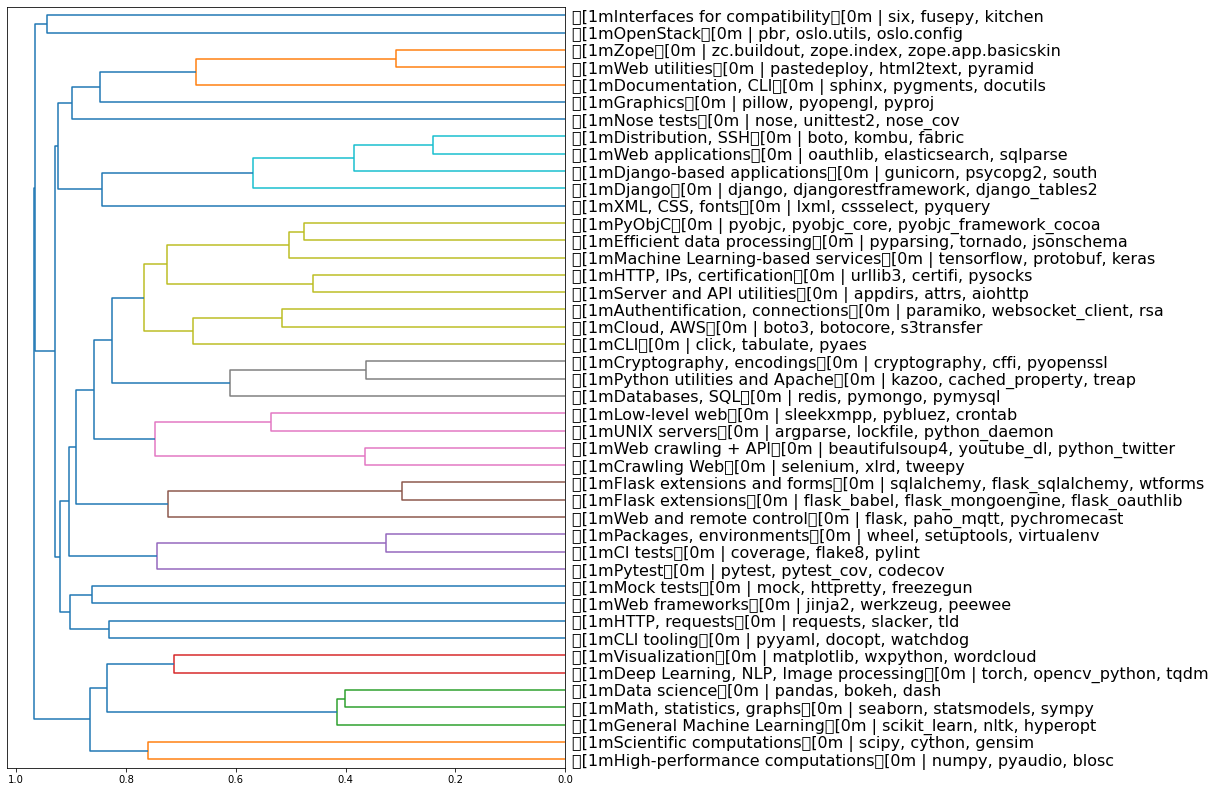

In [64]:
import numpy as np
import pickle

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

X = kmeans.cluster_centers_
n_clusters = len(X)

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='cosine', linkage='average')
model = model.fit(X / np.linalg.norm(X, keepdims=True, axis=1))

plt.title('Hierarchical Clustering Dendrogram')
    # plot the top three levels of the dendrogram
    # plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    # plt.show()
plt.figure(figsize=(10, max(10, n_clusters // 3)))
    # fig = plt.figure()
    # ax = fig.add_subplot(1, 1, 1)
plot_dendrogram(model, truncate_mode='level', p=40, labels=common_labels, color_threshold=.8,
                    orientation='left', leaf_font_size=16)
plt.savefig(f'dendrogram.pdf', bbox_inches='tight', dpi=100, format='pdf')